# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, countDistinct, count, when, sum,col
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Creating a Spark session
spark = (SparkSession.builder 
                    .master("local") 
                    .appName("Creating Features") 
                    .getOrCreate())

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Loading a dataset and marks RDD to be presisted
events = spark.read.json('mini_sparkify_event_data.json')
events.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
events.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
events.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [7]:
events.groupBy("auth").agg(countDistinct("userId")).toPandas()

,auth,count(DISTINCT userId)
0,Logged Out,1
1,Cancelled,52
2,Guest,1
3,Logged In,225


In [8]:
events.groupBy("page").agg(count("userId")).toPandas()

,page,count(userId)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,14457
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,924


In [9]:
events.agg(countDistinct("artist"), 
           countDistinct('song'),
           countDistinct('userAgent')).toPandas()

,count(DISTINCT artist),count(DISTINCT song),count(DISTINCT userAgent)
0,17655,58480,56


In [10]:
# Filters to only userIDs associated with churned users
churned_users = (events.filter(events.page == 'Cancellation Confirmation')
                       .select('userId')
                       .distinct()
                       .rdd.flatMap(lambda x: x)
                       .collect())

# Creates a new field that indicates whether a user churned
events = events.withColumn('Churn', 
                            when(events.userId.isin(churned_users), 1).otherwise(0))

In [11]:
churned_users

['125',
 '51',
 '54',
 '100014',
 '101',
 '29',
 '100021',
 '87',
 '73',
 '3',
 '28',
 '100022',
 '100025',
 '300007',
 '100006',
 '18',
 '70',
 '100005',
 '17',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '103',
 '100024',
 '53',
 '122',
 '200017',
 '58',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '106',
 '143',
 '32',
 '200001',
 '105',
 '200011',
 '100023',
 '100013',
 '100017',
 '121',
 '12',
 '200015',
 '129',
 '200021',
 '100001']

In [12]:
events.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [13]:
type(events)

pyspark.sql.dataframe.DataFrame

In [14]:
# events is exported to the main file directory as a csv file
events.toPandas().to_csv(r'events.csv')

In [15]:
# Filters events data so that only pages that are "NextSong" are displayed
events_songs = events.filter(events.page == 'NextSong')

# # of distinct users
user_count = events_songs.groupby(events_songs.Churn).agg(countDistinct('userId'))

# Total lengths of songs
total_song_length = events_songs.groupby(events_songs.Churn).agg(sum('length'))

# Average length of the songs that were played
average_song_length = (total_song_length.join(user_count, total_song_length.Churn == user_count.Churn)
                                   .drop(user_count.Churn))
average_song_length = average_song_length.withColumn('AvgLength', 
                                             average_song_length['sum(length)']/ average_song_length['count(DISTINCT userId)'])

average_song_length.toPandas()

,sum(length),Churn,count(DISTINCT userId),AvgLength
0,9.048742e+06,1,52,174014.268551
1,4.777688e+07,0,173,276166.937468


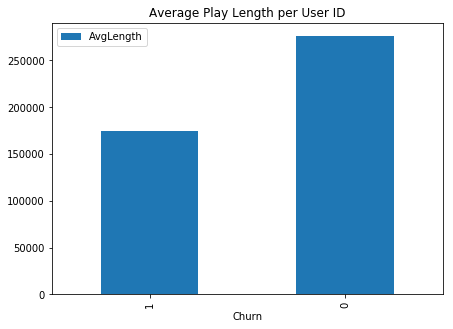

In [16]:
(average_song_length.select('Churn', 'AvgLength')
                .toPandas()
                .set_index('Churn')
                .plot(kind = 'bar', figsize = (7, 5), title = 'Average Play Length per User ID'))

In [17]:
# Creates pivoted table that counts page types by user id
userid_page_pivot = events.groupby(["userId"]).pivot("page").count().fillna(0)

In [18]:
userid_page_pivot = userid_page_pivot.toPandas()
userid_page_pivot.rename(columns={'Cancellation Confirmation': 'Churn'}, inplace = True)

In [19]:
userid_page_pivot

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,...,Register,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Registration,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,...,0,7,0,3,0,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,...,0,52,0,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,...,0,0,1,12,0,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,...,0,4,6,20,0,0,0,41,171,0
5,7,0,1,5,0,0,0,1,1,10,...,0,16,1,3,0,0,0,1,7,2
6,54,5,33,72,1,1,39,1,17,129,...,0,47,3,17,1,0,1,29,163,1
7,15,2,31,59,0,0,28,2,8,93,...,0,1,2,16,0,0,0,14,81,0
8,155,2,11,24,0,0,12,3,9,30,...,0,8,0,5,0,0,1,3,58,2
9,132,4,41,38,0,0,19,3,16,83,...,0,2,4,17,0,0,1,17,96,1


In [20]:
plot_columns = userid_page_pivot.drop('Churn', axis = 1).columns

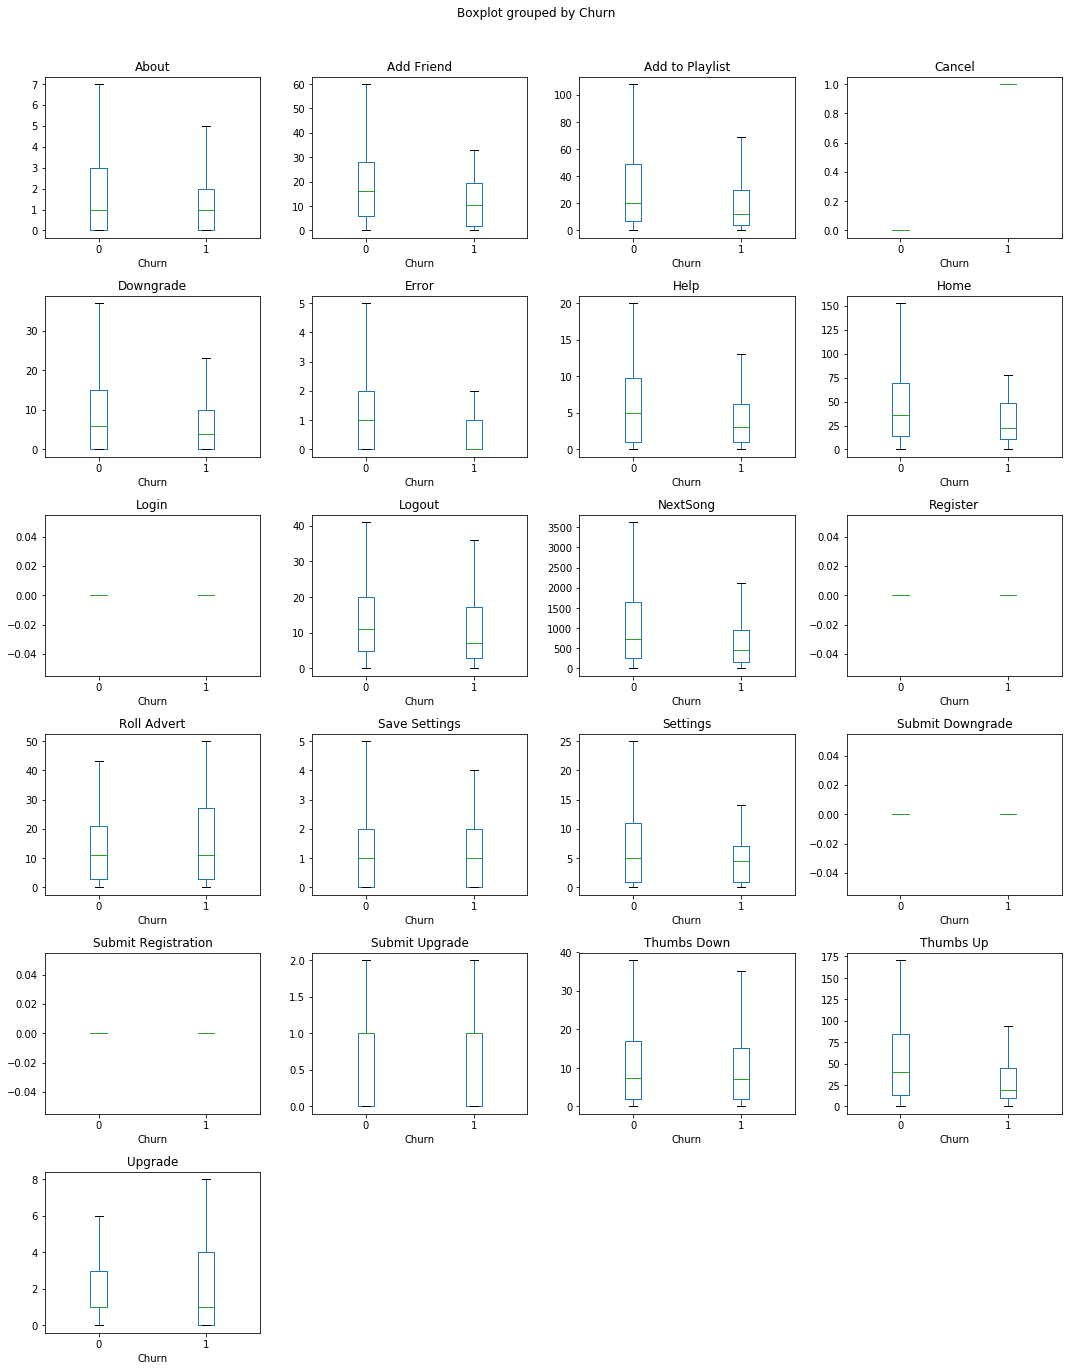

In [21]:
# Displays ranges, percentiles, and averages of users that churned vs those that did not churn per page type
fig = plt.figure(figsize=(15, 20))

for i in range(1,len(plot_columns)):
    axis = fig.add_subplot(6,4,i)
    userid_page_pivot.boxplot(plot_columns[i], ax = axis, 
                         grid = False,  by='Churn', showfliers=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
events_after_drops = events.drop('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'location', 'method', 'song',
                      'status', 'registration')

events_after_drops.toPandas()

,length,level,page,sessionId,ts,userAgent,userId,Churn
0,277.89016,paid,NextSong,29,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,236.09424,free,NextSong,8,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,282.82730,paid,NextSong,29,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,262.71302,free,NextSong,8,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,223.60771,paid,NextSong,29,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
5,208.29995,free,NextSong,8,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
6,260.46649,free,NextSong,8,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
7,185.44281,paid,NextSong,29,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
8,NaN,paid,Add to Playlist,29,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
9,134.47791,paid,NextSong,29,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [23]:
userid_page_pivot = events_after_drops.groupby(["userId"]).pivot("page").count().fillna(0)
userid_page_pivot = userid_page_pivot.drop('About', 'Cancel', 'Login', 'Save Settings', 'Submit Registration', 'Register')

userid_page_pivot.toPandas()

,userId,Add Friend,Add to Playlist,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,4,8,0,5,0,2,20,5,387,7,3,0,1,6,21,2
1,100010,4,7,0,0,0,2,11,5,275,52,0,0,0,5,17,2
2,125,0,0,1,0,0,0,0,0,8,1,0,0,0,0,0,0
3,51,28,52,1,23,1,12,75,24,2111,0,12,0,0,21,100,0
4,124,74,118,0,41,6,23,176,59,4079,4,20,0,0,41,171,0
5,7,1,5,0,0,1,1,10,3,150,16,3,0,0,1,7,2
6,54,33,72,1,39,1,17,129,36,2841,47,17,1,1,29,163,1
7,15,31,59,0,28,2,8,93,27,1914,1,16,0,0,14,81,0
8,155,11,24,0,12,3,9,30,14,820,8,5,0,1,3,58,2
9,132,41,38,0,19,3,16,83,34,1928,2,17,0,1,17,96,1


In [24]:
# Filters "events_after_drops" data so that only pages that are "NextSong" are displayed
events_NextSong = events_after_drops.filter(events_after_drops.page == 'NextSong')

# Variable for total lengths of played songs
total_song_length = events_songs.groupby(events_NextSong.userId).agg(sum('length'))

# Joins "userid_page_pivot" table with "total_song_length" table
userid_page_pivot = (userid_page_pivot.join(total_song_length, on = 'userId', how = 'left')
                            .withColumnRenamed("Cancellation Confirmation", "Churn")
                            .withColumnRenamed("sum(length)", "total_song_length"))

In [25]:
# This variable converts to days
convert = 1000*60*60*24

# Finds the minimum and maximum timestamps of each user
min_timestamp = events_after_drops.select(["userId", "ts"]).groupby("userId").min("ts")
max_timestamp = events_after_drops.select(["userId", "ts"]).groupby("userId").max("ts")

# Determines active days per user
days_active = min_timestamp.join(max_timestamp, on="userId")
days_active = (days_active.withColumn("days_active", 
                                   (col("max(ts)")-col("min(ts)")) / convert))
days_active = days_active.select(["userId", "days_active"])

# Joins "userid_page_pivot" table with "daysActive" table
userid_page_pivot = userid_page_pivot.join(days_active, on = 'userId', how = 'left')

In [26]:
userid_page_pivot.toPandas()

,userId,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active
0,100010,4,7,0,0,0,2,11,5,275,52,0,0,0,5,17,2,6.694090e+04,44.217801
1,200002,4,8,0,5,0,2,20,5,387,7,3,0,1,6,21,2,9.400888e+04,45.496806
2,125,0,0,1,0,0,0,0,0,8,1,0,0,0,0,0,0,2.089113e+03,0.020532
3,124,74,118,0,41,6,23,176,59,4079,4,20,0,0,41,171,0,1.012312e+06,59.996944
4,51,28,52,1,23,1,12,75,24,2111,0,12,0,0,21,100,0,5.232758e+05,15.779398
5,7,1,5,0,0,1,1,10,3,150,16,3,0,0,1,7,2,3.803409e+04,50.784051
6,15,31,59,0,28,2,8,93,27,1914,1,16,0,0,14,81,0,4.773076e+05,54.773183
7,54,33,72,1,39,1,17,129,36,2841,47,17,1,1,29,163,1,7.113449e+05,42.797199
8,155,11,24,0,12,3,9,30,14,820,8,5,0,1,3,58,2,1.987793e+05,25.827836
9,100014,6,7,1,3,0,2,7,3,257,2,1,0,0,3,17,0,6.770347e+04,41.244363


In [27]:
# New table that displauys distinct counts of sessionId per user
session_count = (events_after_drops.select(["userId", "sessionId"])
                      .distinct()
                      .groupby("userId")
                       .count()
                      .withColumnRenamed("count", "session_count"))

# Joins "userid_page_pivot" table with "numSessions" table
userid_page_pivot = userid_page_pivot.join(session_count, on = 'userId', how = 'left')

In [28]:
# Finds the minimum and maximum timestamps of each user with a "paid" level
paid_min_timestamp = events_after_drops.filter(events_after_drops.level == 'paid').groupby("userId").min("ts")
paid_max_timestamp = events_after_drops.filter(events_after_drops.level == 'paid').groupby("userId").max("ts")

# Determines the # of active days of users at the paid level
days_paid_table = paid_min_timestamp.join(paid_max_timestamp, on="userId")
days_paid_table = (days_paid_table.withColumn("days_paid", 
                                (col("max(ts)")-col("min(ts)")) / convert))
days_paid_table = days_paid_table.select(["userId", "days_paid"])

# Joins "userid_page_pivot" table with "daysPaid" table
userid_page_pivot = userid_page_pivot.join(days_paid_table, on = 'userId', how='left')

In [29]:
# Finds the minimum and maximum timestamps of each user with a "free" level
free_min_timestamp = events_after_drops.filter(events_after_drops.level == 'free').groupby("userId").min("ts")
free_max_timestamp = events_after_drops.filter(events_after_drops.level == 'free').groupby("userId").max("ts")

# Determines the # of active days of users at the free level
days_free_table = free_min_timestamp.join(free_max_timestamp, on="userId")
days_free_table = (days_free_table.withColumn("days_free", 
                                (col("max(ts)")-col("min(ts)")) / convert))
days_free_table = days_free_table.select(["userId", "days_free"])

# Joins "userid_page_pivot" table with "daysFree" table
userid_page_pivot = userid_page_pivot.join(days_free_table, on = 'userId', how='left')

In [30]:
# Creates table to display user agent info (browser, operating system, etc.)
user_agent_table = events_after_drops.select(['userId', 'userAgent']).distinct()
user_agent_table = user_agent_table.fillna('Unknown')

# Builds a string indexer to display multiple strings in each cell
string_indexer = StringIndexer(inputCol="userAgent", outputCol="user_agent_index")
model = string_indexer.fit(user_agent_table)
user_agent_table = model.transform(user_agent_table)

# Performs one hot encoding on "userAgents" table
encoder = OneHotEncoder(inputCol="user_agent_index", outputCol="user_agent_vector")
user_agent_table = encoder.transform(user_agent_table).select(['userId', 'user_agent_vector'])

# Joins "userid_page_pivot" table with "userAgents" table
userid_page_pivot = userid_page_pivot.join(user_agent_table, on = 'userId', how ='left')

In [31]:
userid_page_pivot = userid_page_pivot.fillna(0)

In [32]:
userid_page_pivot.toPandas()

,userId,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,Logout,NextSong,...,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active,session_count,days_paid,days_free,user_agent_vector
0,100010,4,7,0,0,0,2,11,5,275,...,0,5,17,2,6.694090e+04,44.217801,7,0.000000,44.217801,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,200002,4,8,0,5,0,2,20,5,387,...,1,6,21,2,9.400888e+04,45.496806,6,28.578646,16.916331,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,125,0,0,1,0,0,0,0,0,8,...,0,0,0,0,2.089113e+03,0.020532,1,0.000000,0.020532,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,124,74,118,0,41,6,23,176,59,4079,...,0,41,171,0,1.012312e+06,59.996944,29,59.996944,0.000000,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,51,28,52,1,23,1,12,75,24,2111,...,0,21,100,0,5.232758e+05,15.779398,10,15.779398,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,7,1,5,0,0,1,1,10,3,150,...,0,1,7,2,3.803409e+04,50.784051,7,0.000000,50.784051,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,15,31,59,0,28,2,8,93,27,1914,...,0,14,81,0,4.773076e+05,54.773183,15,54.773183,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,54,33,72,1,39,1,17,129,36,2841,...,1,29,163,1,7.113449e+05,42.797199,37,42.797199,13.981748,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,155,11,24,0,12,3,9,30,14,820,...,1,3,58,2,1.987793e+05,25.827836,6,19.409132,6.418067,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,100014,6,7,1,3,0,2,7,3,257,...,0,3,17,0,6.770347e+04,41.244363,6,41.244363,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:
userid_page_pivot.columns

['userId',
 'Add Friend',
 'Add to Playlist',
 'Churn',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade',
 'total_song_length',
 'days_active',
 'session_count',
 'days_paid',
 'days_free',
 'user_agent_vector']

In [34]:
# userid_page_pivot is exported to the main file directory as a csv file
userid_page_pivot.toPandas().to_csv(r'userid_page_pivot.csv')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
# Splits data into training and test sets
userid_page_pivot = userid_page_pivot.withColumnRenamed('Churn', 'label')
training, test = userid_page_pivot.randomSplit([0.8, 0.2])

In [36]:
# Training data
training.toPandas()

,userId,Add Friend,Add to Playlist,label,Downgrade,Error,Help,Home,Logout,NextSong,...,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active,session_count,days_paid,days_free,user_agent_vector
0,100010,4,7,0,0,0,2,11,5,275,...,0,5,17,2,6.694090e+04,44.217801,7,0.000000,44.217801,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,200002,4,8,0,5,0,2,20,5,387,...,1,6,21,2,9.400888e+04,45.496806,6,28.578646,16.916331,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,125,0,0,1,0,0,0,0,0,8,...,0,0,0,0,2.089113e+03,0.020532,1,0.000000,0.020532,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,124,74,118,0,41,6,23,176,59,4079,...,0,41,171,0,1.012312e+06,59.996944,29,59.996944,0.000000,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,51,28,52,1,23,1,12,75,24,2111,...,0,21,100,0,5.232758e+05,15.779398,10,15.779398,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,7,1,5,0,0,1,1,10,3,150,...,0,1,7,2,3.803409e+04,50.784051,7,0.000000,50.784051,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,54,33,72,1,39,1,17,129,36,2841,...,1,29,163,1,7.113449e+05,42.797199,37,42.797199,13.981748,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,155,11,24,0,12,3,9,30,14,820,...,1,3,58,2,1.987793e+05,25.827836,6,19.409132,6.418067,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,100014,6,7,1,3,0,2,7,3,257,...,0,3,17,0,6.770347e+04,41.244363,6,41.244363,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,132,41,38,0,19,3,16,83,34,1928,...,1,17,96,1,4.831189e+05,50.497407,16,50.416331,0.080683,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [37]:
# Test data
test.toPandas()

,userId,Add Friend,Add to Playlist,label,Downgrade,Error,Help,Home,Logout,NextSong,...,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active,session_count,days_paid,days_free,user_agent_vector
0,15,31,59,0,28,2,8,93,27,1914,...,0,14,81,0,4.773076e+05,54.773183,15,54.773183,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,11,6,20,0,5,1,3,37,14,647,...,2,9,40,9,1.596700e+05,53.241586,16,47.135498,42.549537,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,112,7,7,0,0,0,1,16,3,215,...,0,3,9,2,5.306275e+04,56.878692,10,0.000000,56.878692,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,34,0,4,0,0,0,0,8,3,53,...,0,0,2,0,1.293108e+04,41.584410,3,0.000000,41.584410,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,59,16,14,0,9,4,3,33,9,724,...,2,9,30,3,1.804348e+05,58.833171,7,54.867442,34.761412,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,8,5,6,0,0,2,0,21,8,251,...,0,3,16,3,6.339353e+04,50.919433,7,0.000000,50.919433,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,22,3,0,0,0,0,0,2,0,28,...,0,0,3,0,7.403821e+03,14.732234,2,0.000000,14.732234,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,28,20,50,1,15,1,7,65,24,1457,...,1,22,79,3,3.648406e+05,35.718877,21,7.461701,28.256956,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,100008,17,30,0,10,0,6,24,7,772,...,0,6,37,4,1.913968e+05,48.999479,6,42.213391,6.784410,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,96,40,52,0,20,2,9,71,24,1802,...,1,24,92,4,4.524924e+05,58.155544,19,58.155544,17.334225,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [38]:
# Creates vector from feature data
feature_names = userid_page_pivot.drop('label', 'userId').schema.names
vec_asembler = VectorAssembler(inputCols = feature_names, outputCol = "Features")

# Scales each column
scalar = MinMaxScaler(inputCol="Features", outputCol="ScaledFeatures")



In [39]:
# Intializes classifiers
lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", 
                        maxIter=10, regParam=0.01)

rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label",
                                numTrees = 50,  featureSubsetStrategy='sqrt')

gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

# Constructs three pipelines
pipeline_lr = Pipeline(stages=[vec_asembler, scalar, lr])
pipeline_rf = Pipeline(stages=[vec_asembler, scalar, rf])
pipeline_gbt = Pipeline(stages=[vec_asembler, scalar, gbt])

In [40]:
# Creates "Features" outcome column, scales data, and fits each model to the data
lr_model = pipeline_lr.fit(training)
rf_model = pipeline_rf.fit(training)
gbt_model = pipeline_gbt.fit(training)

In [41]:
# This function calculates a f1 score and confusion matrix for each model
def modelEvaluations(model, metric, data):
    """ Evaluate a machine learning model's performance 
        Input: 
            model - pipeline object
            metric - the metric of the evaluations
            data - data being evaluated
        Output:
            [score, confusion matrix]
    """
    # generate predictions
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(data)
    
    # calcualte score
    score = evaluator.evaluate(predictions)
    confusion_matrix = (predictions.groupby("label")
                                   .pivot("prediction")
                                   .count()
                                   .toPandas())
    return [score, confusion_matrix]

In [42]:
# Assigns results of the above function to variables
f1_lr, confusion_matrix_lr = modelEvaluations(lr_model, 'f1', test)
f1_rf, confusion_matrix_rf = modelEvaluations(rf_model, 'f1', test)
f1_gbt, confusion_matrix_gbt = modelEvaluations(gbt_model, 'f1', test)

In [43]:
print('The F1 score for the Logistics Regression Classifier model is ', f1_lr)
confusion_matrix_lr

The F1 score for the Logistics Regression Classifier model is  0.7887445887445886


,label,0.0,1.0
0,0,29,3
1,1,5,3


In [44]:
print('The F1 score for the Random Forest Classifier model is ', f1_rf)
confusion_matrix_rf

The F1 score for the Random Forest Classifier model is  0.8114285714285714


,label,0.0,1.0
0,0,32,NaN
1,1,6,2.0


In [45]:
print('The F1 score for the Gradient Boosting Classifier model is ', f1_gbt)
confusion_matrix_gbt

The F1 score for the Gradient Boosting Classifier model is  0.85


,label,0.0,1.0
0,0,29,3
1,1,3,5


In [46]:
# Displays features that are most predictive of the label in the model
feature_importances = np.array(rf_model.stages[-1].featureImportances)
userAgentVec = feature_importances[len(feature_names) :].sum()
feature_importances = feature_importances[:len(feature_names)] + [userAgentVec]

In [47]:
# Converts feature importance data to a pandas dataframe
feature_importance = pd.DataFrame(feature_importances, 
                                     index = feature_names,
                                     columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

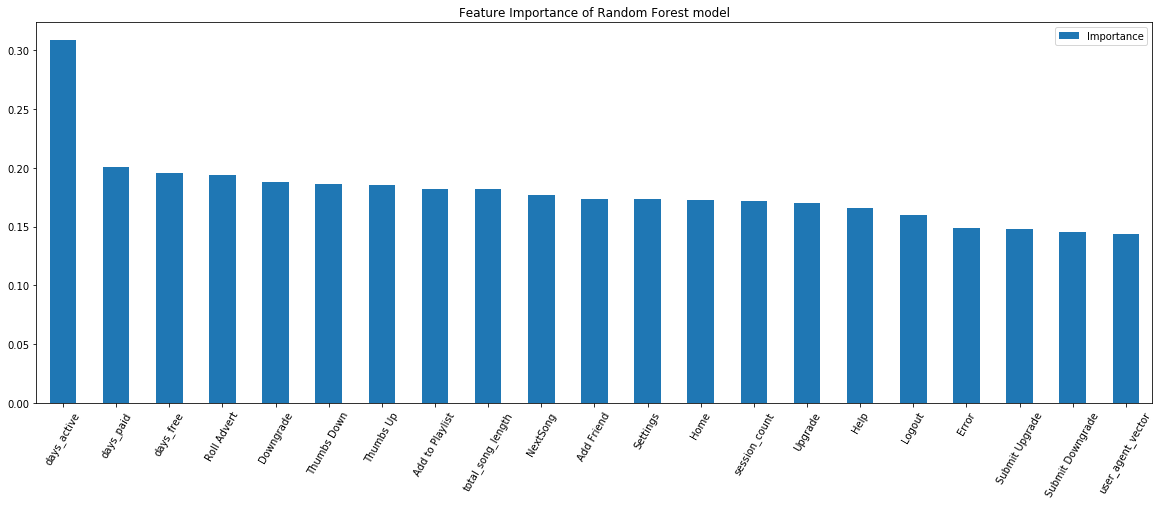

In [48]:
feature_importance.plot(kind = 'bar', figsize = (20, 7), title = 'Feature Importance of Random Forest model')
plt.xticks(rotation = 60)

In [49]:
# feature_importance is exported to the main file directory as a csv file
feature_importance.to_csv(r'feature_importance.csv')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.